Read from a local copy of the ClaimReview Database

### Installation script
```
conda create -n ner python=3.6
source activate ner
conda install -c conda-forge spacy -y
conda install ipython jupyter nb_conda nltk numpy -y
conda install -c conda-forge rake_nltk -y
python -m spacy download en
python -m spacy download en_core_web_sm
python -m spacy download en_core_web_lg
```

In [1]:
import spacy
nlp = spacy.load('en')
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

/anaconda3/envs/ner/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/ner/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/anaconda3/envs/ner/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/ner/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [2]:
import spacy
from spacy.symbols import nsubj, VERB

nlp = spacy.load('en_core_web_sm')
doc = nlp(u"Autonomous cars shift insurance liability toward manufacturers")

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


In [3]:
fc_path = "fact_checks_20180502.txt"

with open(fc_path) as f:
    fc_raw = f.readlines()

In [4]:
print("No. of Claims:", len(fc_raw))

No. of Claims: 8902


Functions to normalise the text

In [5]:
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def strip_html(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

def clean_text(data):
    text = re.sub(r'[^\w\s]', ' ', data.lower()).replace("\n", "").replace("  ", " ")
    text = "".join([c for c in text if (c.isalpha() or c == " ")])
    text = text.split(" ")
    output = ""
    for word in text:
        if word not in stopwords.words("english"):
            output = output + " " + word
    return output.strip().replace("  ", " ")

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:            
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)

def norm_text(data,):
    raw = strip_html(data)
    text = clean_text(raw)
    norm_text = lemmatize_sentence(text)
    return norm_text

In [6]:
from rake_nltk import Rake

# Uses stopwords for english from NLTK, and all puntuation characters by
# default
r = Rake()

# Extraction given the text.
r.extract_keywords_from_text("In August 2018, adhesive replicas of President Donald Trump's recently-destroyed star were placed on the Walk of Fame on Hollywood Boulevard.")

# # Extraction given the list of strings where each string is a sentence.
# r.extract_keywords_from_sentences(<list of sentences>)

# To get keyword phrases ranked highest to lowest.
print(r.get_ranked_phrases())

# To get keyword phrases ranked highest to lowest with scores.
print(r.get_ranked_phrases_with_scores())

['president donald trump', 'hollywood boulevard', 'destroyed star', 'august 2018', 'adhesive replicas', 'walk', 'recently', 'placed', 'fame']
[(9.0, 'president donald trump'), (4.0, 'hollywood boulevard'), (4.0, 'destroyed star'), (4.0, 'august 2018'), (4.0, 'adhesive replicas'), (1.0, 'walk'), (1.0, 'recently'), (1.0, 'placed'), (1.0, 'fame')]


In [7]:
# # ATTEMPTED TO EXTRACT THE VERBS WHICH IS NOT VERY HELPFUL

# import numpy as np
# random_point = np.random.randint(len(fc_raw)-200)
# print(random_point)

# for fc in fc_raw[random_point:random_point+10]:
#     fc = fc.strip("\n")
#     fc = fc.replace("</script>", "").replace('<script type="application/ld+json">', "")
#     fc = json.loads(fc)
#     claim = fc["claimReviewed"]
# #     date_published = fc["datePublished"]
#     review_url = fc["url"]
    
#     print("Claim:", claim)
#     r.extract_keywords_from_text(claim)
#     r.get_ranked_phrases()
#     print(r.get_ranked_phrases_with_scores())
#     doc = nlp(claim)
    
#     # EXTRACTING VERBS WHICH IS NOT VERY HELPFUL
#     print([(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents])
#     verbs = set()
#     for possible_subject in doc:
#         if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
#             verbs.add(possible_subject.head)
#     print(verbs)
#     print()

# DEMO

In [7]:
sentence_array = [
# verbatim 
# 'Actor Jim Carrey said that the United States is "morally upside down."',
# 'Liberty University students "were mandated" to attend Sen. Ted Cruz’s presidential \
# announcement "or they would be fined.',
# 'A photograph shows a baseball stadium repurposed as a residential neighborhood.',
# 'Folding a $5 bill in a specific pattern will reveal a secret image of a stack of pancakes.',
# paraphrase
# 'Donald Trump mocked "someone with a disability."',
'The fact that President Trump mocked someone with a disability shows how idiotic he is.',
# 'We can see how Paul Ryan is a coward when he blocked all incoming calls and faxes.',
# 'Being tough on drug is stupid when you know that more people die from prescription \
# narcotic painkillers than from heroin and cocaine combined.',
# 'Barack Obama was arrested for bringing drugs to Japan.'
]
# here I am comparing the text with every claim. 
# If the keyword is spread across sentences they need to be retested again.

In [8]:
text = "".join(sentence_array)
from rake_nltk import Rake
r1 = Rake()
r1.extract_keywords_from_text(text)
r1_scored = r1.get_ranked_phrases_with_scores()
print(r1_scored)

[(16.0, 'president trump mocked someone'), (4.0, 'disability shows'), (1.0, 'idiotic'), (1.0, 'fact')]


In [19]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
from rake_nltk import Rake

nlp = spacy.load('en_core_web_lg')

def calculate_similarity_score(value_mesh, r1_scored, r2_scored):
    similarity_array = np.maximum.reduce([row for row in value_mesh[0]])
    weighted_similarity = np.multiply(similarity_array, [keyword_tuple[0] for keyword_tuple in r1_scored])
    weighted_similarity_sum = np.sum(weighted_similarity)
    sum_of_weights = np.sum([keyword_tuple[0] for keyword_tuple in r1_scored])
    weighted_similarity_sum_over_weights = weighted_similarity_sum/sum_of_weights
    return weighted_similarity_sum_over_weights

def phrase_vect(text):
    tokens = nlp(text)
    maxpool = np.maximum.reduce([token.vector for token in tokens])
    return maxpool
#     minpool = np.minimum.reduce([token.vector for token in tokens])
#     # https://stackoverflow.com/questions/21816433/
#     result = np.concatenate((minpool,maxpool))
#     return result

def meshgrid(x,y): # DW code !!!
    return (
        [[x_ for x_ in x] for  _ in y],
        [[y_ for  _ in x] for y_ in y])

def cosine(u,v):
#     print(np.shape(u))
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

def calculate_claim_text(claim, text):
    r1 = Rake()
    r1.extract_keywords_from_text(claim)
    r1_scored = r1.get_ranked_phrases_with_scores()
    print(r1_scored)

    r2 = Rake()
    r2.extract_keywords_from_text(text)
    r2_scored = r2.get_ranked_phrases_with_scores()
#     print(r2_scored)
    
    # assign vectors
    r1_scored_vec = [[claim_keyword_tuple[0], 
                      claim_keyword_tuple[1], 
                      phrase_vect(claim_keyword_tuple[1])] for claim_keyword_tuple in r1_scored]
#     print(len(r1_scored_vec))
#     print(len(r1_scored_vec[0]))

    r2_scored_vec = [[text_keyword_tuple[0], 
                      text_keyword_tuple[1], 
                      phrase_vect(text_keyword_tuple[1])] for text_keyword_tuple in r2_scored]
#     print(len(r1_scored_vec))
#     print(len(r1_scored_vec[0]))
    
    
    # compare statements

    pair_mesh = meshgrid(r1_scored_vec, r2_scored_vec)
    value_mesh = meshgrid([0]*len(r1_scored_vec), [0]*len(r2_scored_vec))

    import numpy as np
    for i,_ in enumerate(pair_mesh[0]):
        for j,_ in enumerate(pair_mesh[0][0]): 
            vector1 = pair_mesh[0][i][j][2]
            vector2 = pair_mesh[1][i][j][2]

            value_mesh[0][i][j] = cosine(vector1, vector2)
            
    return calculate_similarity_score(value_mesh, r1_scored, r2_scored)

100
Claim: Actor Jim Carrey said that the United States is "morally upside down."
[(16.0, 'actor jim carrey said'), (4.0, 'united states'), (4.0, 'morally upside'), (1.0, '."')]
0.9727924621105194
Claim: Liberty University students "were mandated" to attend Sen. Ted Cruz’s presidential announcement "or they would be fined."
[(9.0, 'ted cruz ’'), (9.0, 'liberty university students'), (4.0, 'presidential announcement'), (4.0, 'fined ."'), (4.0, 'attend sen'), (1.0, 'would'), (1.0, 'mandated')]
0.9496786929666996
Claim: A photograph shows a baseball stadium repurposed as a residential neighborhood.
[(9.0, 'baseball stadium repurposed'), (4.0, 'residential neighborhood'), (4.0, 'photograph shows')]
0.9999999859753776
Claim: Folding a $5 bill in a specific pattern will reveal a secret image of a stack of pancakes.
[(4.0, 'specific pattern'), (4.0, 'secret image'), (4.0, '5 bill'), (1.0, 'stack'), (1.0, 'reveal'), (1.0, 'pancakes'), (1.0, 'folding')]
1.0000000149011612
Claim: Says Donald Tru

0.770034380497471
Claim: A lawyer for Tashfeen Malik asked the media not to show photographs of her face because doing so was offensive to Muslims, and MSNBC host Melissa Harris-Perry criticized the New York Times for publishing such pictures.
[(16.0, 'msnbc host melissa harris'), (9.0, 'tashfeen malik asked'), (9.0, 'new york times'), (4.0, 'show photographs'), (4.0, 'perry criticized'), (1.0, 'publishing'), (1.0, 'pictures'), (1.0, 'offensive'), (1.0, 'muslims'), (1.0, 'media'), (1.0, 'lawyer'), (1.0, 'face')]
0.7783228949624665
Claim: Photograph shows 5,000 UCLA students holding "a candlelight vigil for fallen ISIS soldiers."
[(16.0, 'fallen isis soldiers ."'), (16.0, '000 ucla students holding'), (9.0, 'photograph shows 5'), (4.0, 'candlelight vigil')]
0.7354954481124878
Claim: Photograph shows eleven original staff members of Microsoft in 1978.
[(36.0, 'photograph shows eleven original staff members'), (1.0, 'microsoft'), (1.0, '1978')]
0.7729424489171881
Claim: "If we don't save 

0.7782002286985517
Claim: In Wisconsin, "300,000 voters were turned away by the state’s strict voter ID law" in the 2016 presidential election.
[(16.0, 'strict voter id law'), (9.0, '2016 presidential election'), (4.0, 'turned away'), (4.0, 'state ’'), (4.0, '000 voters'), (1.0, 'wisconsin'), (1.0, '300')]
0.7119008287405356
Claim: President Trump has purchased the Mount Desert Island estate of David Rockefeller.
[(16.0, 'mount desert island estate'), (4.0, 'president trump'), (4.0, 'david rockefeller'), (1.0, 'purchased')]
0.7774220204353333
Claim: "Since 1990, production of metals in the U.S. has held roughly constant, but the number of people employed in the industry has fallen steadily."
[(9.0, 'held roughly constant'), (9.0, 'fallen steadily ."'), (4.0, 'since 1990'), (4.0, 'people employed'), (1.0, 'u'), (1.0, 'production'), (1.0, 'number'), (1.0, 'metals'), (1.0, 'industry')]
0.6777789506220049
Claim: Photograph shows Barack Obama without his hand over his heart while the U.S. n

0.7196977883577347
Claim: White House Press Secretary Sean Spicer retweeted a satirical item from 'The Onion'  about himself.
[(49.0, 'white house press secretary sean spicer retweeted'), (4.0, 'satirical item'), (1.0, 'onion')]
0.8151182775144223
Claim: Director Michael Moore was accused of sexual harassment by a 16-year-old film extra.
[(9.0, 'old film extra'), (9.0, 'director michael moore'), (4.0, 'sexual harassment'), (1.0, 'year'), (1.0, 'accused'), (1.0, '16')]
0.7727694284915924
Claim: President Trump "vetoed" Argentina's decision to honor Jimmy Carter in April 2017.
[(9.0, 'honor jimmy carter'), (4.0, 'president trump'), (4.0, 'april 2017'), (1.0, 'vetoed'), (1.0, 'decision'), (1.0, 'argentina')]
0.7258070766925812
Claim: A lesbian was removed from a women's bathroom by police in North Carolina because she wasn't feminine enough.
[(4.0, 'north carolina'), (4.0, 'feminine enough'), (1.0, 'women'), (1.0, 'removed'), (1.0, 'police'), (1.0, 'lesbian'), (1.0, 'bathroom')]
0.7057523

0.7242724309044499
Claim: Production of Coors Light beer has been halted due the brew's being contaminated with cocaine.
[(9.0, 'coors light beer'), (4.0, 'halted due'), (1.0, 'production'), (1.0, 'contaminated'), (1.0, 'cocaine'), (1.0, 'brew')]
0.7244986330761629
Claim: "The FBI has become America's secret police …  like the old KGB."
[(16.0, 'secret police … like'), (9.0, 'old kgb ."'), (4.0, 'become america'), (1.0, 'fbi')]
0.7210415800412496
Claim: “Trump has made his plans for immigrants and their families clear.”
[(9.0, 'families clear .”'), (4.0, '“ trump'), (1.0, 'plans'), (1.0, 'made'), (1.0, 'immigrants')]
0.6766925491392612
Claim: George Soros was arrested and charged with hate crimes against America.
[(4.0, 'hate crimes'), (4.0, 'george soros'), (1.0, 'charged'), (1.0, 'arrested'), (1.0, 'america')]
0.7419256297024813
Claim: Retired Marine Col. Jeffery Powers penned an open letter to NFL commissioner Roger Goodell describing how he felt about players kneeling during the na

0.7431049775658992
Claim: A rogue Amazon drone attempted to deliver a bomb to the White House.
[(16.0, 'rogue amazon drone attempted'), (4.0, 'white house'), (1.0, 'deliver'), (1.0, 'bomb')]
0.8126951320604845
Claim: Says Barack Obama complained that Democrats continue to ignore blacks except at election time.
[(16.0, 'says barack obama complained'), (9.0, 'ignore blacks except'), (4.0, 'election time'), (4.0, 'democrats continue')]
0.743727339036537
Claim: A North Carolina provider of mental health services is named "Nutz R Us."
[(16.0, 'nutz r us ."'), (9.0, 'north carolina provider'), (9.0, 'mental health services'), (1.0, 'named')]
0.7531666108540126
Claim: Joint Chiefs of Staff Chairman Joseph Dunford announced his retirement with a fiery political resignation speech.
[(25.0, 'staff chairman joseph dunford announced'), (16.0, 'fiery political resignation speech'), (4.0, 'joint chiefs'), (1.0, 'retirement')]
0.8308832813864169
Claim: Mike Pence supported "gay conversion" therapy, i

0.7799297752587692
Claim: Activities by foreign governments had "absolutely no effect on the outcome of this election."
[(4.0, 'foreign governments'), (4.0, 'election ."'), (1.0, 'outcome'), (1.0, 'effect'), (1.0, 'activities'), (1.0, 'absolutely')]
0.7390840699275335
Claim: A pilot refused to let President Obama onboard a helicopter after he failed to salute a Marine.
[(16.0, 'let president obama onboard'), (4.0, 'pilot refused'), (1.0, 'salute'), (1.0, 'marine'), (1.0, 'helicopter'), (1.0, 'failed')]
0.780815601348877
Claim: Caitlyn Jenner will pose nude on the cover of 'Sports Illustrated.'
[(9.0, "sports illustrated .'"), (4.0, 'pose nude'), (4.0, 'caitlyn jenner'), (1.0, 'cover')]
0.6764993071556091
Claim: A megalodon capsized a South African charter vessel in April 2013.
[(16.0, 'south african charter vessel'), (4.0, 'megalodon capsized'), (4.0, 'april 2013')]
0.7605013251304626
Claim: Photograph shows Donald Trump supporters wearing "Make America White Again" shirts at a rally.


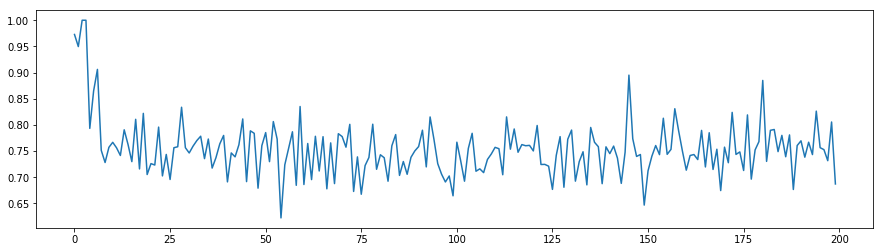

In [20]:
import numpy as np
random_point = np.random.randint(len(fc_raw)-200)
random_point = 100
print(random_point)

similarity_array = []

for fc in fc_raw[random_point:random_point+200]:
    fc = fc.strip("\n")
    fc = fc.replace("</script>", "").replace('<script type="application/ld+json">', "")
    fc = json.loads(fc)
    claim = fc["claimReviewed"]
#     date_published = fc["datePublished"]
    review_url = fc["url"]
    print("Claim:", claim)
    similarity = calculate_claim_text(claim, text)
    print(similarity)
    similarity_array.append(similarity)
    
plt.figure(figsize=(15,4))
plt.plot(similarity_array)
plt.show()